# Grad-CAM
An example of implementation with PyTorch

In [32]:
import torch
import timm
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [38]:
# Define the function

def generate_gradcam(model, input_tensor, target_class, target_layer):
    model.eval()

    # 1. Store feature maps and gradients
    activations = []
    gradients = []

    def forward_hook(module, input, output): # capture feature maps of that layer
        activations.append(output.detach())

    def backward_hook(module, grad_input, grad_output): # capture gradients of output score wrt each feature map
        gradients.append(grad_output[0].detach())

    # 2. Register hooks - basically making sure that feature maps and corresponding gradients of our layer of interest are recorded
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # 3. Forward pass
    output = model(input_tensor) # output
    pred_class = output.argmax(dim=1).item() # extract logit for class=1 (malignant)

    # 4. Backward pass for target class
    model.zero_grad()
    class_score = output[:, target_class]
    class_score.backward() # Compute dy/DA where A it output, A is feature map (matrix)

    # 5. Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # 6. Get the stored activations and gradients
    grad = gradients[0]         # shape: [B, C, H, W]
    act = activations[0]        # shape: [B, C, H, W] - feature maps
    weights = grad.mean(dim=(2, 3), keepdim=True)  # global average pooling

    # 7. Compute weighted combination
    cam = (weights * act).sum(dim=1, keepdim=True)
    cam = F.relu(cam) # because we only case about positive influences
    cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False) # from pixel to heatmap2
    # you can uncomment the line above if you want to see "Pixelated" values instead of heatmap
    
    # 8. Normalize for visualization
    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    return cam, pred_class

In [35]:
# Get data (for binary only)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts to [0, 1]
])

class BreakHisDataset(Dataset): # Subclass Dataset, which is required for using DataLoader
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.le = LabelEncoder()
        self.df['label'] = self.le.fit_transform(self.df['label']) # convert to binary
        self.class_names = list(self.le.classes_)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'filepath']
        label = self.df.loc[idx, 'label']
        #subtype = self.df.loc[idx, 'label_diagnosis']   
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)


# For original (non-augumented) data
gradcam = BreakHisDataset(csv_path="../data/metadata.csv", transform=transform)
gradcam_loader = DataLoader(gradcam, batch_size=32, shuffle=True)

In [ ]:
# Import saved model
model = timm.create_model('convnextv2_atto.fcmae', pretrained=False, num_classes=2) # model architecture
model.load_state_dict(torch.load("convnext_v2_outputs/Single_Model/best_model_binary.pth")) # saved weights
model.eval()

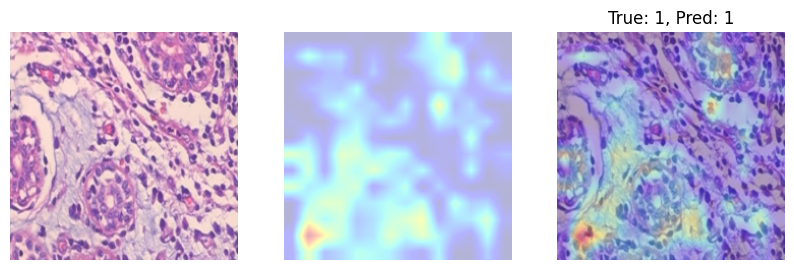

In [48]:
# Apply to images of interest

from PIL import Image

target_layer = list(model.stages[2].children())[-1][1] # choose target layer

# Get a batch from test_loader
img_iter = iter(gradcam_loader) # comment out after 1st run if want to keep iterating over images
image_batch, label_batch = next(img_iter)
image = image_batch[0].unsqueeze(0)
label = label_batch[0].item()

# Run Grad-CAM
cam, pred_class = generate_gradcam(model, image, target_class=0, target_layer=target_layer)

f, ax = plt.subplots(nrows = 1, ncols=3, figsize = (10, 4))
ax[0].imshow(to_pil_image(image.squeeze())) # normal image
ax[1].imshow(cam, cmap='jet', alpha=0.3) # heatmap
ax[2].imshow(to_pil_image(image.squeeze())) # overlaid Grad-CAM
ax[2].imshow(cam, cmap='jet', alpha=0.3)
plt.title(f"True: {label}, Pred: {pred_class}")
for i in range(3):
    ax[i].axis('off')
plt.show()